# K-Means Clustering

KMeans is a basic but powerful clustering method which is optimized via Expectation Maximization. 

It randomly selects K data points in X, and computes which samples are close to these points. For every cluster of points, a mean is computed, and this becomes the new centroid.

cuML’s KMeans supports the scalable KMeans++ intialization method. This method is more stable than randomnly selecting K points.

[Docs](https://docs.rapids.ai/api/cuml/stable/api.html#k-means-clustering)

## Generate Data

In [1]:
import cudf

In [2]:
df = cudf.read_csv('https://github.com/gumdropsteve/datasets/raw/master/iris.csv')

In [3]:
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,species,target
145,6.7,3.0,5.2,2.3,virginica,2
146,6.3,2.5,5.0,1.9,virginica,2
147,6.5,3.0,5.2,2.0,virginica,2
148,6.2,3.4,5.4,2.3,virginica,2
149,5.9,3.0,5.1,1.8,virginica,2


Let's take 80% of our data for training, and leave the other 20% for testing.

Clustering will be determined based on 4 parameters (sepal_length, sepal_width, petal_length, petal_width) and the accuracy of the clusters can be termined by compairing to the target (y).

In [4]:
from cuml.preprocessing.model_selection import train_test_split

In [5]:
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

y = df['target']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## cuML KMeans

Fit the model with our training data. As training is just holding the data, this almost takes no time at all. 

The model can take array-like objects, either in host as NumPy arrays or in device (as Numba or cuda_array_interface-compliant), as well as cuDF DataFrames as the input.


In [7]:
from cuml.cluster import KMeans as KMeans

In [8]:
kmeans = KMeans(n_clusters=3)

In [9]:
kmeans.fit(X_train)

KMeans(handle=<cuml.common.handle.Handle object at 0x7f14ed288ed0>, n_clusters=3, max_iter=300, tol=0.0001, verbose=0, random_state=1, init='scalable-k-means++', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cudf')

### Visualize 

Let's see what the model is working with. We can plot our clusters with Matplotlib.

In [10]:
import cupy
import matplotlib.pyplot as plt

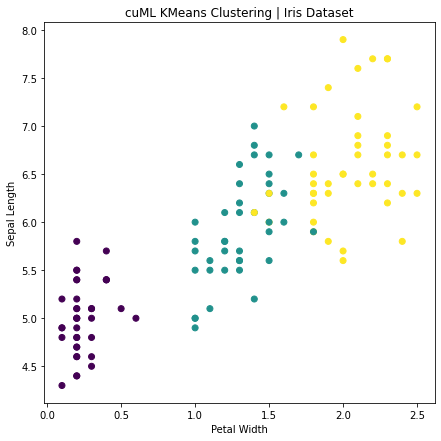

In [11]:
fig = plt.figure(figsize=(7, 7))

plt.scatter(x=X_train.petal_width.to_pandas(), 
            y=X_train.sepal_length.to_pandas(), 
            c=y_train.to_pandas())

plt.title('cuML KMeans Clustering | Iris Dataset')
plt.xlabel('Petal Width')
plt.ylabel('Sepal Length')

plt.show()

## Make Predictions
Our model has data on 120 different flowers. Let's give it 30 more and see which cluster it thinks each belongs in.

In [12]:
preds = kmeans.predict(X_test)

In [13]:
preds.tail()

25    2
26    0
27    0
28    2
29    0
dtype: int32

## Score Results
We can score our model with cuML's adjusted_rand_score, which is a [Rand index](https://en.wikipedia.org/wiki/Rand_index) adjusted for chance.

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:
```python
ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
```
The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

In [14]:
from cuml.metrics import adjusted_rand_score

In [15]:
score = adjusted_rand_score(labels_true=y_test.to_array(), 
                            labels_pred=preds.to_array())

/home/winston/anaconda3/envs/bsql/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:  The dtype of ground truth is not int32 converting the ground truth to int32
  
/home/winston/anaconda3/envs/bsql/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:  The dtype of predicted labels is not int32 converting the predicted labels to int32
  
/home/winston/anaconda3/envs/bsql/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [16]:
score

0.8463838402862793

Because train_test_split returns our X_test set as a cudf.DataFrame, we can easily add columns for the `predicted` and `actual` values.

Note: The model was never made aware of the actual clusters, and came up with its own, so compairing the `predicted` and `actual` patterns will give you a more accurate understanding than compairing the `predicted` and `actual` values here. _For high scores on this dataset, this usually means the 2s match up and the 1s and 0s are flipped._

In [17]:
results_df = X_test.copy()

results_df['actual'] = y_test.values
results_df['predicted'] = preds.values

results_df

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
120,4.8,3.4,1.6,0.2,0,0
121,6.1,3.0,4.6,1.4,1,2
122,6.9,3.2,5.7,2.3,2,1
123,7.3,2.9,6.3,1.8,2,1
124,5.0,3.4,1.6,0.4,0,0
125,5.0,3.0,1.6,0.2,0,0
126,5.7,2.8,4.1,1.3,1,2
127,4.6,3.2,1.4,0.2,0,0
128,4.9,2.5,4.5,1.7,2,2
129,6.1,3.0,4.9,1.8,2,1
